# Lesson 11 Notes

## Purpose of the Exercise: Derivation of the vortex-source panel method.

In [35]:
import numpy
import math
from matplotlib import pyplot
# embed the figures into the notebook
%matplotlib inline
%run ./definitions.ipynb

import os
import numpy
from scipy import integrate, linalg

### Lifting-body panel method

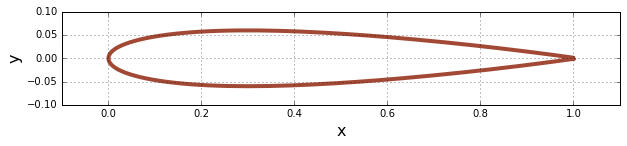

In [23]:
# load geometry
naca_filepath = os.path.join('resources','naca0012.dat')
with open(naca_filepath, 'r') as infile:
    x, y = numpy.loadtxt(infile, dtype=float, unpack=True)
    
# and plot geometry, just to check in
width = 10
pyplot.figure(figsize=(width,width))
pyplot.grid()
pyplot.xlabel('x',fontsize=16)
pyplot.ylabel('y',fontsize=16)
pyplot.plot(x,y,color='#A24936', linestyle='-', linewidth=4)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

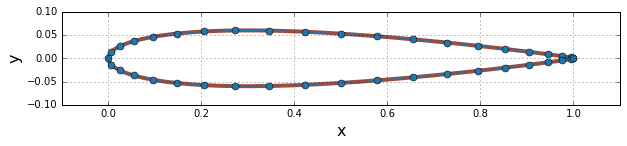

In [24]:
# discretize into panels
panels = define_panels(x,y,N=40)

# and plot this
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='#A24936', linestyle='-', linewidth=4)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=7, color='#2176AE')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);


In [25]:
# define freestream condition
freestream = Freestream(u_inf=1.0, alpha=4.0)

In [26]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [37]:
A = build_singularity_matrix(A_source, B_vortex)
C = build_singularity_matrix(B_vortex, A_source)
b = build_freestream_rhs(panels, freestream)

In [38]:
# solve for strengths
srcstrengths = numpy.linalg.solve(A, b)
vortstrengths = numpy.linalg.solve(C, b)

# store strength per panel
for i, panel in enumerate(panels):
    panel.sigma = srcstrengths[i]
    
for i, panel in enumerate(panels):
    panel.gamma = vortstrengths[i]
    
# store circulaton density
gamma = strengths[-1]

In [39]:
# tangential velocity at each panel center
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

In [40]:
# surface pressure coefficient
compute_pressure_coefficient(panels, freestream)

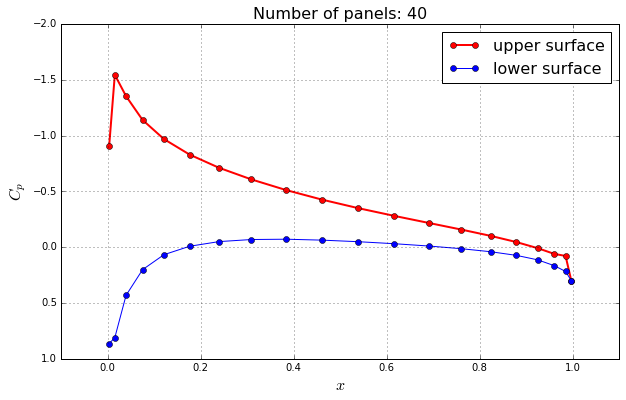

In [41]:
# plot dat
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -2.0)
pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);

In [47]:
# check accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.004606


In [48]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels)
        - min(panel.xa for panel in panels))
cl = (gamma*sum(panel.length for panel in panels)
      / (0.5*freestream.u_inf*c))
print('lift coefficient: CL = {:0.3f}'.format(cl))

lift coefficient: CL = 0.506


### Challenge task

Based on what has been done in the previous notebook, compute and plot the streamlines and the pressure coefficient on a Cartesian grid.


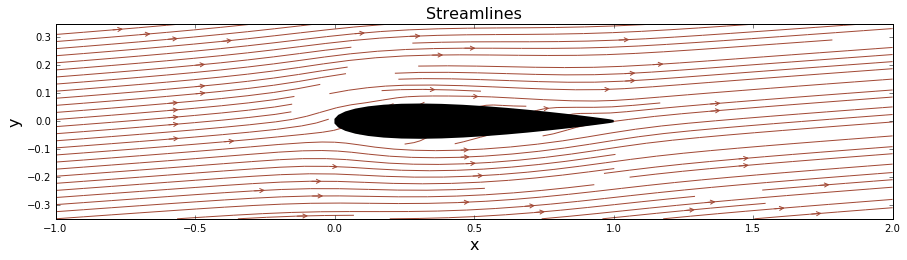

In [42]:
n = 20
xa, xz = -1.0, 2.0
ya, yz = -0.35, 0.35
x,y,X,Y = makemesh(n,xa,xz,ya,yz)

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)

# plot the velocity field
width = 15
pyplot.figure(figsize=(width, width*2))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v, density=1, linewidth=1, color='#A24936', arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],[panel.yc for panel in panels],color='black', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(xa, xz)
pyplot.ylim(ya, yz)
pyplot.title('Streamlines', fontsize=16);

## edit get_velocity_field to include source AND vortex

In [45]:
print(panel.gamma)
print(panel.sigma)

-6.19759754678e+12
0.0114313654622


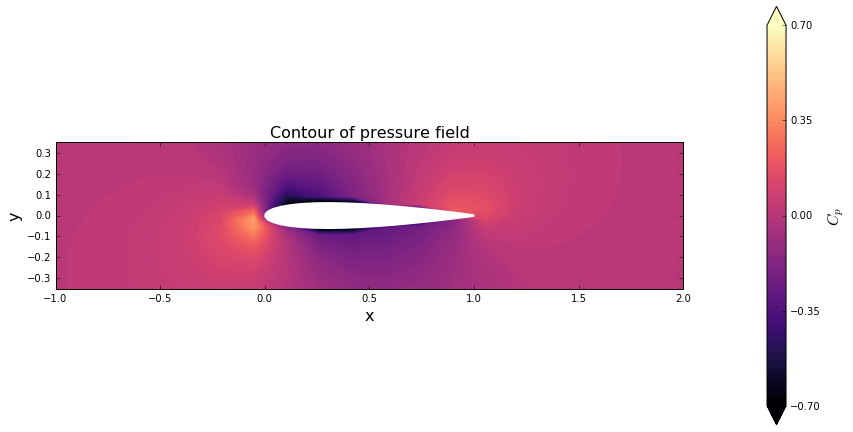

In [46]:
# computing and plotting pressure field

cp = 1.0 - (u**2+v**2)/freestream.u_inf**2

width = 15
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cp, levels=numpy.linspace(-0.7, 0.7, 100), extend='both', cmap='magma')
cbar = pyplot.colorbar(contf, orientation='vertical', shrink=0.5, pad = 0.1, ticks=[-0.7, -0.35, 0.0, 0.35, 0.7])
cbar.set_label('$C_p$', fontsize=16)
pyplot.fill([panel.xc for panel in panels], [panel.yc for panel in panels], color='white', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(xa, xz)
pyplot.ylim(ya, yz)
pyplot.title('Contour of pressure field', fontsize=16);